

For this analysis, we're modeling a **4:1 split-rate tax** where land is taxed at four times the rate of buildings.

## Policy Definition for South Bend

For this analysis, we're modeling:
- **Revenue-neutral** property tax split for the South Bend School Corporation
- **4:1 land-to-building tax ratio** (partial LVT shift)
- **Existing exemptions and abatements** continue to apply
- **Focus on school corporation taxes** (which bypass Indiana's property tax caps)

Let's begin by importing the necessary libraries and utility functions.


In [1]:
import sys
import pandas as pd
sys.path.append('..')  # Add parent directory to path
from cloud_utils import get_feature_data, get_feature_data_with_geometry
from lvt_utils import model_split_rate_tax, calculate_current_tax
from census_utils import get_census_data, get_census_blockgroups_shapefile, get_census_data_with_boundaries, match_to_census_blockgroups



## Step 1: Getting the Data

The first step in modeling an LVT shift is obtaining property tax data. Most counties make this information publicly accessible through open data portals or GIS systems.

For St. Joseph County (which includes South Bend), we can access parcel data through their ArcGIS services. The base URL below provides access to various property datasets including:

- **Parcel_Civic**: Main parcel dataset with tax information, property types, and assessed values
- **parcel_boundaries**: Geographic boundaries for spatial analysis

### Key Data Elements We Need:
- **Full Market Value (FMV)**: Total assessed property value
- **Land Value**: Assessed value of land only  
- **Improvement Value**: Assessed value of buildings/structures
- **Exemption amounts**: Various tax exemptions applied
- **Property characteristics**: Type, location, tax district

Let's fetch the main parcel dataset:


In [56]:

# Base URL for the ArcGIS services
base_url = "https://services.arcgis.com/OjftlhRHkAABcyiF/arcgis/rest/services"
# Fetch the main parcel dataset with tax info
parcel_civic_df = get_feature_data('Parcel_Civic', base_url)


Total records in Parcel_Civic: 119632
Fetched records 0 to 2000 for Parcel_Civic
Fetched records 2000 to 4000 for Parcel_Civic
Fetched records 4000 to 6000 for Parcel_Civic
Fetched records 6000 to 8000 for Parcel_Civic
Fetched records 8000 to 10000 for Parcel_Civic
Fetched records 10000 to 12000 for Parcel_Civic
Fetched records 12000 to 14000 for Parcel_Civic
Fetched records 14000 to 16000 for Parcel_Civic
Fetched records 16000 to 18000 for Parcel_Civic
Fetched records 18000 to 20000 for Parcel_Civic
Fetched records 20000 to 22000 for Parcel_Civic
Fetched records 22000 to 24000 for Parcel_Civic
Fetched records 24000 to 26000 for Parcel_Civic
Fetched records 26000 to 28000 for Parcel_Civic
Fetched records 28000 to 30000 for Parcel_Civic
Fetched records 30000 to 32000 for Parcel_Civic
Fetched records 32000 to 34000 for Parcel_Civic
Fetched records 34000 to 36000 for Parcel_Civic
Fetched records 36000 to 38000 for Parcel_Civic
Fetched records 38000 to 40000 for Parcel_Civic
Fetched record

## Step 2: Filtering to South Bend School Corporation

Now we need to filter our dataset to include only properties within our area of interest. For this analysis, we're focusing on the South Bend School Corporation tax district.

### Why Focus on School Corporation Taxes?

In Indiana, most properties hit statutory tax caps that limit property tax increases. However, the South Bend School Corporation passed a referendum that allows them to exceed these caps, making it an ideal case study for LVT modeling where tax changes can actually take effect.

We'll filter for:
- Properties in South Bend city limits (`PROP_CITY` contains 'SOUTH BEND')  
- Properties in South Bend tax districts (`TAXDIST` contains 'SB')


In [57]:
df = parcel_civic_df.copy()[parcel_civic_df['PROP_CITY'].str.upper().str.contains('SOUTH BEND', na=False)]
df = df[df['TAXDIST'].str.contains('SB')].copy()

## Step 3: Recreating Current Property Tax Revenue

Before we can model an LVT shift, we need to accurately recreate the current property tax system. This validation step ensures our dataset correctly reflects the real-world tax landscape.

### Key Components:
- **Millage Rate**: $3.3 per $1,000 in assessed value (from South Bend School Corporation budget)
- **Exemptions**: Various exemptions that reduce taxable value
- **Exempt Properties**: Fully exempt properties (marked in `PROPTYPE`)

### The Process:
1. Calculate total exemptions from all exemption amount fields
2. Identify fully exempt properties  
3. Calculate taxable value (land + improvements - exemptions)
4. Apply millage rate to get current tax liability
5. Verify total revenue matches published budget expectations (~$27 million)

This step is crucial - if we can't accurately recreate current taxes, our LVT projections won't be reliable.


In [58]:

millage_rate = 3.3
df['millage_rate'] = millage_rate

# 1. Calculate current tax
df['exemption_flag'] = df['PROPTYPE'].apply(lambda x: 1 if 'Exempt' in x else 0)
print(f"Number of exempt properties: {df['exemption_flag'].sum():,} ({df['exemption_flag'].mean()*100:.1f}%)")

df['total_exemptions'] = df[['ExemptAmt1', 'ExemptAmt2', 'ExemptAmt3', 'ExemptAmt4', 'ExemptAmt5', 'ExemptAmt6']].sum(axis=1)
# Calculate taxable value (land + improvements)
df['taxable_value'] = df['REALLANDVA'] + df['REALIMPROV']

current_revenue, second_revenue,df = calculate_current_tax(
    df=df, 
    tax_value_col='taxable_value',
    millage_rate_col='millage_rate',
    exemption_col='total_exemptions',
    exemption_flag_col='exemption_flag'
)


print(f"Total number of properties: {len(df):,}")
print(f"Current annual revenue with ${millage_rate*1000}/1000 millage rate: ${current_revenue:,.2f}")
print(f"Total land value: ${df['REALLANDVA'].sum():,.2f}")
print(f"Total improvement value: ${df['REALIMPROV'].sum():,.2f}")



Number of exempt properties: 0 (0.0%)
Total current tax revenue: $28,405,584.84
Total number of properties: 44,221
Current annual revenue with $3300.0/1000 millage rate: $28,405,584.84
Total land value: $893,530,500.00
Total improvement value: $8,249,030,200.00


## Step 4: Modeling the Split-Rate Land Value Tax

Now for the exciting part - modeling the LVT shift! We'll create a revenue-neutral policy that taxes land at 4 times the rate of buildings.

### The Split-Rate Formula

Under our proposed system:
- **Buildings** are taxed at a lower rate (Building Millage)  
- **Land** is taxed at 4x that rate (4 × Building Millage)
- **Total revenue** remains the same as current system

The formula to solve for the building millage rate is:
```
Current Revenue = (Building Millage × Total Taxable Buildings) + (4 × Building Millage × Total Taxable Land)
```

### Handling Exemptions in Split-Rate System

Since we want to maintain existing exemptions, we need to:
1. Apply exemptions to building value first
2. If exemptions exceed building value, apply remainder to land value
3. Calculate separate taxable values for land and buildings

This ensures properties don't over-benefit from exemptions and maintains the intent of existing tax policy.


In [59]:
# Calculate split-rate tax using model_split_rate_tax function
land_millage, improvement_millage, new_revenue, df = model_split_rate_tax(
    df=df,
    land_value_col='REALLANDVA',
    improvement_value_col='REALIMPROV',
    current_revenue=current_revenue,
    land_improvement_ratio=4  # 4:1 ratio as specified
)

# Calculate tax changes manually since they're not being added by the function
df['NEW_TAX'] = (df['REALLANDVA'] * land_millage/1000) + (df['REALIMPROV'] * improvement_millage/1000)
df['TAX_CHANGE'] = df['new_tax'] - df['current_tax']
df['TAX_CHANGE_PCT'] = (df['TAX_CHANGE'] / df['current_tax']) * 100


Split-rate tax model (Land:Improvement = 4:1)
Land millage rate: 9.6102
Improvement millage rate: 2.4025
Total tax revenue: $28,405,584.84
Target revenue: $28,405,584.84
Revenue difference: $0.00 (0.0000%)


## Step 5: Understanding Property Types and Impacts

With our split-rate tax calculated, we can now analyze which property types are most affected. Understanding the distribution of tax impacts across different property categories is crucial for policy makers and stakeholders.

### Property Type Analysis

We'll examine how the tax burden shifts across:
- **Residential properties** (single-family, multi-family, condos)
- **Commercial properties** (retail, office, industrial)  
- **Vacant land** (often sees largest increases under LVT)
- **Exempt properties** (government, religious, charitable)

### Key Metrics to Track:
- **Count**: Number of properties in each category
- **Median tax change**: Typical impact (less affected by outliers)
- **Average percentage change**: Overall magnitude of impact
- **Percentage with increases**: How many properties see tax increases

This analysis helps identify which sectors benefit from the LVT shift (typically developed properties) and which see increased burden (typically land-intensive properties with low improvement ratios).


In [60]:
# For each column, show top 10 most common values and their counts
columns_to_analyze = ['CLASSCODE', 'TOWNSHIP', 'TAXDIST', 'Neighborho', 'PROPTYPE', 
                     'TAXTYPE', 'TIFAREAUID', 'LEGALDESCR']

for col in columns_to_analyze:
    print(f"\nTop 10 values for {col}:")
    value_counts = df[col].value_counts().head(10)
    print(value_counts)
    print(f"Total unique values: {df[col].nunique()}")
    print("-" * 50)

# Let's also look at some basic statistics about these groups
print("\nMedian tax changes by various groupings:")

for col in ['CLASSCODE', 'TOWNSHIP', 'TAXDIST', 'PROPTYPE']:
    print(f"\nMedian tax change by {col}:")
    median_changes = df.groupby(col)['TAX_CHANGE'].agg([
        'count',
        'median',
        lambda x: (x > 0).mean() * 100  # Percentage with increase
    ]).round(2)
    median_changes.columns = ['Count', 'Median Change ($)', '% With Increase']
    print(median_changes.sort_values('Count', ascending=False).head(10))


Top 10 values for CLASSCODE:
CLASSCODE
510    32934
500     3359
640     1029
551      836
520      632
550      480
429      381
456      315
680      293
685      281
Name: count, dtype: int64
Total unique values: 102
--------------------------------------------------

Top 10 values for TOWNSHIP:
TOWNSHIP
Portage    37412
Centre      3859
German      1694
Clay         855
Penn         392
Warren         9
Name: count, dtype: int64
Total unique values: 6
--------------------------------------------------

Top 10 values for TAXDIST:
TAXDIST
SB Portage    37412
SB Centre      3859
SB German      1694
SB Clay         855
SB Penn         392
SB Warren         9
Name: count, dtype: int64
Total unique values: 6
--------------------------------------------------

Top 10 values for Neighborho:
Neighborho
7126296    1823
7126222    1055
7126282    1048
7126287    1033
7126225    1021
7126262     997
7126234     937
7126218     886
7126422     851
7126208     841
Name: count, dtype: int64
Tota

In [61]:
# Improved property type categorization for South Bend data

def categorize_property_type(prop_type):
    # Defensive: handle missing/nulls
    if not isinstance(prop_type, str):
        return "Other"

    # Normalize for matching
    p = prop_type.strip().upper()

    # Single Family
    if p.startswith("1 FAMILY DWELL - PLATTED LOT"):
        return "Single Family"
    elif p.startswith("1 FAMILY DWELL - UNPLATTED (0 TO 9.99 ACRES)"):
        return "Single Family - Unplatted Small Acreage"
    elif p.startswith("1 FAMILY DWELL - UNPLATTED (10 TO 19.99 ACRES)"):
        return "Single Family - Unplatted Medium Acreage"
    elif p.startswith("1 FAMILY DWELL - UNPLATTED"):
        return "Single Family - Unplatted Large Acreage"

    # Multi-Family
    if "2 FAMILY" in p or "3 FAMILY" in p or "4 TO 19 FAMILY" in p:
        return "Small Multi-Family (2-19 units)"
    if "20 TO 39 FAMILY" in p or "40 OR MORE FAMILY" in p:
        return "Large Multi-Family (20+ units)"

    # Condos
    if "CONDOMINIUM" in p:
        return "Condominiums"

    # Mobile/Manufactured
    if "MOBILE" in p or "MANUFACTURED" in p:
        return "Mobile/Manufactured Homes"

    # Retail
    if any(x in p for x in [
        "RETAIL", "SHOP", "STORE", "MARKET", "DEPARTMENT", "SHOPPING CENTER",
        "SUPERMARKET", "DISCOUNT AND JUNIOR DEPARTMENT STORE", "COMMUNITY SHOPPING CENTER",
        "NEIGHBORHOOD SHOPPING CENTER", "REGIONAL SHOPPING CENTER", "FULL LINE DEPARTMENT STORE"
    ]):
        return "Retail Commercial"

    # Office
    if any(x in p for x in [
        "OFFICE", "MEDICAL CLINIC", "BANK", "SAVING & LOANS", "DRIVE-UP/WALK-UP ONLY BANK",
        "OFFICE BLDG", "INDUSTRIAL OFFICE"
    ]):
        return "Office Commercial"

    # Food/Hospitality
    if any(x in p for x in [
        "RESTAURANT", "BAR", "HOTEL", "MOTEL", "FOOD", "CAFETERIA", "CONVENIENCE MARKET"
    ]):
        return "Food/Hospitality"

    # Industrial
    if any(x in p for x in [
        "INDUSTRIAL", "MANUFACTURING", "WAREHOUSE", "ASSEMBLY", "FACTORY", "FOUNDRIES",
        "TRUCK TERMINAL", "COMMERCIAL MINI-WAREHOUSE", "COMMERCIAL TRUCK TERMINAL",
        "MEDIUM MANUFACTURING", "LIGHT MANUFACTURING", "RESEARCH & DEVELOPMENT FACILITY"
    ]):
        return "Industrial"

    # Vacant Land
    if p.startswith("VACANT") or "VACANT LAND" in p:
        return "Vacant Land"

    # Parking
    if "PARKING" in p:
        return "Parking"

    # Government
    if any(x in p for x in [
        "EXEMPT, MUNICIPALITY", "EXEMPT, COUNTY", "EXEMPT, STATE OF INDIANA",
        "EXEMPT, UNITED STATES OF AMERICA", "EXEMPT, BOARD OF EDUCATION",
        "EXEMPT, TOWNSHIP", "EXEMPT PROPERTY OWNED BY A MUNICIPAL HOUSING AUTHORITY",
        "EXEMPT PROPERTY OWNED BY A PUBLIC LIBRARY", "EXEMPT, PARK DISTRICT"
    ]):
        return "Government"

    # Religious
    if any(x in p for x in [
        "EXEMPT, RELIGIOUS ORGANIZATION", "EXEMPT, CHURCH", "EXEMPT, CHAPEL",
        "EXEMPT, MOSQUE", "EXEMPT, SYNAGOGUE", "EXEMPT, TEMPLE",
        "EXEMPT, CHURCH, CHAPEL, MOSQUE, SYNAGOGUE, TABERNACLE, OR TEMPLE",
        "EXEMPT, CEMETERY ORGANIZATION"
    ]):
        return "Religious"

    # Charitable
    if "EXEMPT, CHARITABLE ORGANIZATION" in p:
        return "Charitable"

    # Agricultural
    if any(x in p for x in [
        "FARM", "AGRICULTURAL", "GRAIN", "LIVESTOCK", "DAIRY", "NURSERY", "POULTRY", "GREENHOUSES"
    ]):
        return "Agricultural"

    # Special: Nursing, Medical, Funeral, etc.
    if any(x in p for x in [
        "NURSING HOME", "PRIVATE HOSPITAL", "FUNERAL HOME"
    ]):
        return "Health/Institutional"

    # Utility/Infrastructure
    if any(x in p for x in [
        "UTILITY", "RAILROAD", "TELEPHONE", "TELEGRAPH", "CABLE COMPANY", "POWER", "LIGHT, HEAT"
    ]):
        return "Utility/Infrastructure"

    # If still not matched, try broad fallback
    if "EXEMPT" in p:
        return "Other Exempt"
    if "COMMERCIAL" in p:
        return "Other Commercial"
    if "RESIDENTIAL" in p:
        return "Other Residential"

    return "Other"

# Apply the function to the DataFrame
df['PROPERTY_CATEGORY'] = df['PROPTYPE'].apply(categorize_property_type)

# Print unique property categories
print("Unique PROPERTY_CATEGORY values:")
print(df['PROPERTY_CATEGORY'].unique())

# Print unique PROPTYPE values
print("\nUnique PROPTYPE values:")
print(df['PROPTYPE'].unique())


Unique PROPERTY_CATEGORY values:
['Vacant Land' 'Single Family' 'Industrial'
 'Small Multi-Family (2-19 units)' 'Office Commercial' 'Food/Hospitality'
 'Retail Commercial' 'Large Multi-Family (20+ units)' 'Religious'
 'Government' 'Other Residential' 'Parking' 'Condominiums' 'Charitable'
 'Other Commercial' 'Utility/Infrastructure' 'Other Exempt' 'Other'
 'Mobile/Manufactured Homes' 'Single Family - Unplatted Small Acreage'
 'Health/Institutional' 'Agricultural'
 'Single Family - Unplatted Medium Acreage']

Unique PROPTYPE values:
['VACANT - PLATTED LOT' '1 FAMILY DWELL - PLATTED LOT'
 'COMMERCIAL WAREHOUSE' '2 FAMILY DWELL - PLATTED LOT'
 'OFFICE BLDG (1 OR 2 STORY)' 'RESTAURANT, CAFETERIA OR BAR'
 'LIGHT MANUFACTURING & ASSEMBLY' 'OTHER RETAIL STRUCTURES' 'VACANT LAND'
 '40 OR MORE FAMILY APARTMENTS' 'EXEMPT, RELIGIOUS ORGANIZATION'
 'EXEMPT, MUNICIPALITY' 'INDUSTRIAL WAREHOUSE'
 'OTHER RESIDENTIAL STRUCTURES' 'PARKING LOT OR STRUCTURE'
 'CONDOMINIUM UNIT - PLATTED LOT' 'EXEMPT, CHAR

### Creating Detailed Property Categories

To better understand impacts, we'll create a detailed property categorization system that groups similar property types together. This makes the analysis more meaningful and interpretable.

The function below categorizes properties into groups like:
- **Single Family** (with subcategories by lot size)
- **Multi-Family** (small vs. large)
- **Commercial** (by type: retail, office, industrial)
- **Exempt** (by type: government, religious, charitable)

This categorization helps us understand not just that "residential" properties are affected, but specifically which types of residential properties see the biggest changes.


In [62]:
# Create a summary DataFrame grouped by PROPTYPE
proptype_analysis = df.groupby('PROPERTY_CATEGORY').agg({
    'TAX_CHANGE_PCT': 'mean',  # Average percentage change
    'TAX_CHANGE': 'median',    # Median dollar change
    'PARCELID': 'count'        # Count of properties
}).round(2)

# Add percentage that increase
proptype_increases = df.groupby('PROPERTY_CATEGORY').agg({
    'TAX_CHANGE': lambda x: (x > 0).mean() * 100  # Percentage with increase
}).round(2)

proptype_analysis['Percent_Increased'] = proptype_increases['TAX_CHANGE']

# Rename columns for clarity
proptype_analysis.columns = [
    'Avg_Pct_Change',
    'Median_Dollar_Change',
    'Property_Count',
    'Pct_Properties_Increased'
]

# Sort by count of properties (descending)
proptype_analysis = proptype_analysis.sort_values('Property_Count', ascending=False)

# Print results
print("Analysis by Property Type:\n")
print("Note: All monetary values in dollars, percentages shown as %\n")
print(proptype_analysis.to_string())

# Print some summary statistics
print("\nOverall Summary:")
print(f"Total properties analyzed: {proptype_analysis['Property_Count'].sum():,}")
print(f"Overall median dollar change: ${df['TAX_CHANGE'].median():,.2f}")
print(f"Overall average percent change: {df['TAX_CHANGE_PCT'].mean():.2f}%")
print(f"Overall percent of properties with increase: {(df['TAX_CHANGE'] > 0).mean()*100:.2f}%")

Analysis by Property Type:

Note: All monetary values in dollars, percentages shown as %

                                          Avg_Pct_Change  Median_Dollar_Change  Property_Count  Pct_Properties_Increased
PROPERTY_CATEGORY                                                                                                       
Single Family                                        inf                -43.13           32934                     25.24
Vacant Land                                          inf                 25.24            3694                     99.92
Government                                           NaN                  0.00            1409                      0.00
Condominiums                                       -8.10               -123.19            1331                     20.66
Small Multi-Family (2-19 units)                      inf                -31.58             913                     22.23
Retail Commercial                                  15.63       

### Summary of Tax Impacts by Property Category

Now we can see the clear patterns of how different property types are affected by the LVT shift. This table will show us:

- **Which property types benefit** (negative changes = tax decreases)
- **Which property types pay more** (positive changes = tax increases)  
- **How concentrated the impacts are** (median vs. average differences)
- **What percentage of each type sees increases**

Generally, we expect:
- **Developed properties** (houses, commercial buildings) to see tax **decreases**
- **Vacant land** to see the **largest increases** 
- **Properties with high improvement-to-land ratios** to benefit most


In [63]:
boundary_gdf = get_feature_data_with_geometry('parcel_boundaries', base_url=base_url)


Total records in parcel_boundaries: 119736
Fetched records 0 to 2000 of 119736
Fetched records 2000 to 4000 of 119736
Fetched records 4000 to 6000 of 119736
Fetched records 6000 to 8000 of 119736
Fetched records 8000 to 10000 of 119736
Fetched records 10000 to 12000 of 119736
Fetched records 12000 to 14000 of 119736
Fetched records 14000 to 16000 of 119736
Fetched records 16000 to 18000 of 119736
Fetched records 18000 to 20000 of 119736
Fetched records 20000 to 22000 of 119736
Fetched records 22000 to 24000 of 119736
Fetched records 24000 to 26000 of 119736
Fetched records 26000 to 28000 of 119736
Fetched records 28000 to 30000 of 119736
Fetched records 30000 to 32000 of 119736
Fetched records 32000 to 34000 of 119736
Fetched records 34000 to 36000 of 119736
Fetched records 36000 to 38000 of 119736
Fetched records 38000 to 40000 of 119736
Fetched records 40000 to 42000 of 119736
Fetched records 42000 to 44000 of 119736
Fetched records 44000 to 46000 of 119736
Fetched records 46000 to 4

## Step 6: Adding Geographic Context

To make our analysis spatially-aware, we need to add geographic boundaries to our parcel data. This enables us to:

- **Create maps** showing tax changes across the city
- **Analyze patterns by neighborhood** or district  
- **Combine with demographic data** for equity analysis
- **Present results visually** to stakeholders

We'll fetch the parcel boundary data from the same ArcGIS service that contains the geometric information for each property.


In [64]:

print(len(df))

# Merge with our tax analysis data
merged_gdf = df.merge(
    boundary_gdf,
    on='PARCELID',
    how='inner'
)

print(f"\nMerged data has {len(merged_gdf)} parcels")
merged_gdf_2 = merged_gdf.copy()

44221

Merged data has 44711 parcels


### Merging Tax Analysis with Geographic Data

Here we combine our tax analysis results with the geographic boundaries. This creates a spatially-enabled dataset that allows us to:

1. **Map tax changes** across South Bend
2. **Identify spatial patterns** in tax impacts
3. **Prepare for demographic analysis** by having geographic context

The merge should give us the same number of records as our original analysis, now with geographic coordinates for each parcel.


In [65]:
# Get census data for St. Joseph County (FIPS code: 18141)
census_data, census_boundaries = get_census_data_with_boundaries(
    fips_code='18141',  # Indiana (18) + St. Joseph County (141)
    year=2022,
    api_key='e22bb2247fdb11c140fc8aa531e952a1e11539b7'  # Replace with your actual Census API key
)

# Set CRS for census boundaries before merging
census_boundaries = census_boundaries.set_crs(epsg=4326)  # Assuming WGS84 coordinate system
boundary_gdf = boundary_gdf.set_crs(epsg=4326)  # Set same CRS for boundary data

# Merge census data with our parcel boundaries
merged_gdf = match_to_census_blockgroups(
    gdf=boundary_gdf,
    census_gdf=census_boundaries,
    join_type="left"
)

# Merge the census data back onto the original dataframe
df = df.merge(
    merged_gdf,
    left_on='PARCELID',
    right_on='PARCELID',
    how='left'
)

print(f"Number of census blocks: {len(census_boundaries)}")
print(f"Number of census data: {len(census_data)}")
print(f"Number of parcels with census data: {len(df)}")

Number of census blocks: 8260
Number of census data: 237
Number of parcels with census data: 44711


## Step 7: Demographic and Equity Analysis

One of the most important aspects of LVT analysis is understanding the **equity implications** - how does the tax shift affect different income levels and demographic groups?

### Adding Census Data

We'll match each property to its Census Block Group and pull demographic data including:
- **Median household income** 
- **Racial/ethnic composition**
- **Population characteristics**

### Why This Matters

Policy makers need to understand:
- Does the LVT shift disproportionately burden low-income neighborhoods?
- Are there racial equity implications?  
- Does the policy align with broader equity goals?

**Note**: You'll need a Census API key for this section. Get one free at: https://api.census.gov/data/key_signup.html


In [66]:
print("DataFrame columns:")
print(df.columns.tolist())


DataFrame columns:
['FID_x', 'PARCELID', 'TAXTYPE', 'TAXUNITUID', 'PARCELSTAT_x', 'LEGALDESCR', 'PAYYEAR', 'NAME_1', 'MAILINGADD', 'MAILINGA_1', 'MAILINGCIT', 'MAILINGSTA', 'MAILINGZIP', 'TIFAREAUID', 'TIFAREASSE', 'REALLANDVA', 'REALIMPROV', 'TLLDIMPROV', 'MAPREFEREN', 'TOWNSHIP', 'TAXDIST', 'TAXUNIT', 'Neighborho', 'CLASSCODE', 'SALESDATE', 'SALESPRICE', 'TRANSFERDA', 'TRANSFERRE', 'PROP_ADDR', 'PROP_CITY', 'PROP_STATE', 'PROP_ZIP', 'Total_Fini', 'PTaxPayYr', 'PastTNetTa', 'ID', 'TaxPayYr', 'TnetTax', 'Exempt1', 'ExemptAmt1', 'Exempt2', 'ExemptAmt2', 'Exempt3', 'ExemptAmt3', 'Exempt4', 'ExemptAmt4', 'Exempt5', 'ExemptAmt5', 'Exempt6', 'ExemptAmt6', 'F_AREA', 'ACREAGE', 'PARCPRC', 'PROVALWBLK', 'PAYTAXURL', 'PROPTYPE', 'TAXINFOURL', 'DATEUPDATE', 'YEAR_BUILT', 'POINT_X', 'POINT_Y', 'Shape__Area_x', 'Shape__Length_x', 'millage_rate', 'exemption_flag', 'total_exemptions', 'taxable_value', 'current_tax', 'land_tax', 'improvement_tax', 'new_tax', 'tax_change', 'tax_change_pct', 'NEW_TAX',

### Exploring the Enhanced Dataset

With census data merged in, our dataset now contains both property tax information and demographic context. Let's explore what variables we now have available for analysis.

This enhanced dataset allows us to examine relationships between:
- Property characteristics and demographics
- Tax impacts and neighborhood income levels
- Geographic patterns in tax burden shifts


In [67]:
# Display all columns with maximum width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df.head())


,FID_x,PARCELID,TAXTYPE,TAXUNITUID,PARCELSTAT_x,LEGALDESCR,PAYYEAR,NAME_1,MAILINGADD,MAILINGA_1,MAILINGCIT,MAILINGSTA,MAILINGZIP,TIFAREAUID,TIFAREASSE,REALLANDVA,REALIMPROV,TLLDIMPROV,MAPREFEREN,TOWNSHIP,TAXDIST,TAXUNIT,Neighborho,CLASSCODE,SALESDATE,SALESPRICE,TRANSFERDA,TRANSFERRE,PROP_ADDR,PROP_CITY,PROP_STATE,PROP_ZIP,Total_Fini,PTaxPayYr,PastTNetTa,ID,TaxPayYr,TnetTax,Exempt1,ExemptAmt1,Exempt2,ExemptAmt2,Exempt3,ExemptAmt3,Exempt4,ExemptAmt4,Exempt5,ExemptAmt5,Exempt6,ExemptAmt6,F_AREA,ACREAGE,PARCPRC,PROVALWBLK,PAYTAXURL,PROPTYPE,TAXINFOURL,DATEUPDATE,YEAR_BUILT,POINT_X,POINT_Y,Shape__Area_x,Shape__Length_x,millage_rate,exemption_flag,total_exemptions,taxable_value,current_tax,land_tax,improvement_tax,new_tax,tax_change,tax_change_pct,NEW_TAX,TAX_CHANGE,TAX_CHANGE_PCT,PROPERTY_CATEGORY,FID_y,PARCELSTAT_y,Shape__Area_y,Shape__Length_y,geometry,OID,STATE,COUNTY,TRACT,BLKGRP,BLOCK,SUFFIX,GEOID,LWBLKTYP,UR,AREAWATER,AREALAND,MTFCC,NAME,BASENAME,LSADC,FUNCSTAT,CENTLON,CENTLAT,INTPTLON,INTPTLAT,HU100,POP100,OBJECTID,state_fips,county_fips,tract_fips,bg_fips,std_geoid,median_income,total_pop,white_pop,black_pop,hispanic_pop,state,county,tract,census_block_group,minority_pct,black_pct
0,1,018-2102-3841,R,18,71-03-34-330-022.000-026,Lot 369 Vernon Hts & E 1/2 VAC alley W & ad...,2027,PALAZZOLA JACQUELINE,1741 Meade St,,South Bend,IN,46628,0,0,6300,0,0,3-34F,Portage,SB Portage,18,7126429,500,12/5/2012,25,6/3/2014,3683QC,1735 N MEADE ST,SOUTH BEND,IN,46628,0,2023 Payable 2024,213.20,2303,2024 Payable 2025,0.00,,,,,,,,,,,,,5664.37382239717,0.13,https://engageblob.blob.core.windows.net/stjos...,https://engage.xsoftinc.com/stjoseph/Map/GetPa...,https://enoticesonline.com/index.php/stj?filte...,VACANT - PLATTED LOT,https://lowtaxinfo.com/sjcounty?parcelNumber=7...,08/27/2025,0,-86.286609,41.698438,944.679688,148.206764,3.3,0,0.0,6300,20.79,60.543984,0.000000,60.543984,39.753984,191.216854,60.543984,39.753984,191.216854,Vacant Land,4620,71-03-34-330-022.000-026,944.679688,148.206764,"POLYGON ((-86.28635 41.69839, -86.28687 41.698...",210701004396017,18,141,000200,4,4010,None,181410002004010,L,U,0,10464,G5040,Block 4010,4010,BK,S,-086.2865296,+41.6983153,-086.2865296,+41.6983153,4.0,8.0,7448818.0,18,141,000200,4,181410002004,57000.0,1028.0,286.0,589.0,0.0,18,141,000200,4,72.18,57.30
1,2,018-2103-3871,R,18,71-03-34-331-014.000-026,Lot 309 Vernon Hts,2027,EAC SOUTH BEND LLC,309 S Logan St,,South Bend,IN,46615,0,0,6200,33400,0,3-34F,Portage,SB Portage,18,7126589,510,3/16/2013,21900,4/19/2018,23355WR,1733 FREMONT ST,SOUTH BEND,IN,46628,624,2023 Payable 2024,667.52,2304,2024 Payable 2025,0.00,,,,,,,,,,,,,5283.7139368968,0.12,https://engageblob.blob.core.windows.net/stjos...,https://engage.xsoftinc.com/stjoseph/Map/GetPa...,https://enoticesonline.com/index.php/stj?filte...,1 FAMILY DWELL - PLATTED LOT,https://lowtaxinfo.com/sjcounty?parcelNumber=7...,08/27/2025,1947,-86.285345,41.698445,881.187500,141.863102,3.3,0,0.0,39600,130.68,59.582968,80.244804,139.827773,9.147773,7.000132,139.827773,9.147773,7.000132,Single Family,4622,71-03-34-331-014.000-026,881.187500,141.863102,"POLYGON ((-86.2851 41.6984, -86.2856 41.6984, ...",210701004396015,18,141,000200,4,4027,None,181410002004027,L,U,0,21079,G5040,Block 4027,4027,BK,S,-086.2856096,+41.6983293,-086.2856096,+41.6983293,12.0,39.0,7448816.0,18,141,000200,4,181410002004,57000.0,1028.0,286.0,589.0,0.0,18,141,000200,4,72.18,57.30
2,3,018-2141-5304,R,18,71-03-35-329-016.000-026,Lot 34 Holmans Sub Of Lots 57-61 Portage Hts,2027,MAY J FINDLEY JR,3021 Greene St,,South Bend,IN,46628,0,0,7000,103200,0,3-35F,Portage,SB Portage,18,7126411,510,9/16/2014,701,9/25/2014,10012XD,1010 ROOSEVELT ST,SOUTH BEND,IN,46616,2016,2023 Payable 2024,963.14,2309,2024 Payable 2025,0.00,,,,,,,,,,,,,5157.52643482773,0.12,https://engageblob.blob.core.windows.net/stjos...,https://engage.xsoftinc.com/stjoseph/Map/GetPa...,https://enoticesonline.com/index.php/stj?filte...,1 FAMILY DWELL - PLATTED LOT,https://lowtaxinfo.com/sjcount

### Viewing the Complete Dataset

Let's examine our enhanced dataset with all the variables we've created and merged. This gives us a comprehensive view of each property with:

- **Property characteristics** (type, value, location)
- **Current tax calculations** 
- **New LVT calculations**
- **Tax change impacts**
- **Demographic context** (income, race/ethnicity)

This rich dataset forms the foundation for sophisticated equity and impact analysis.


Number of rows in gdf_filtered: 43602
Number of rows in non_vacant_gdf: 40975


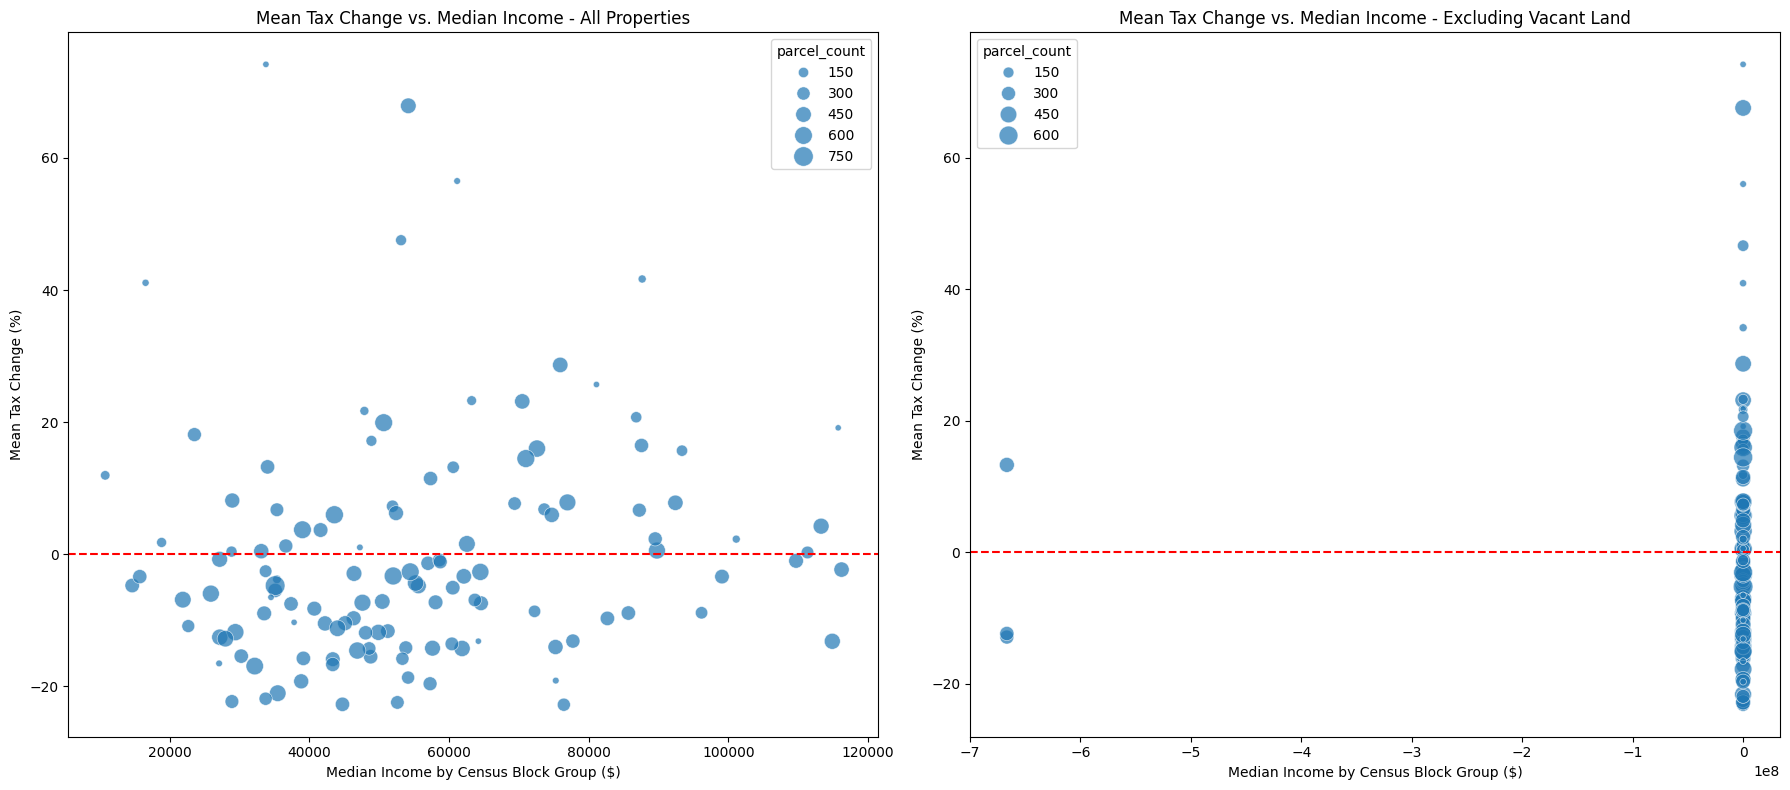

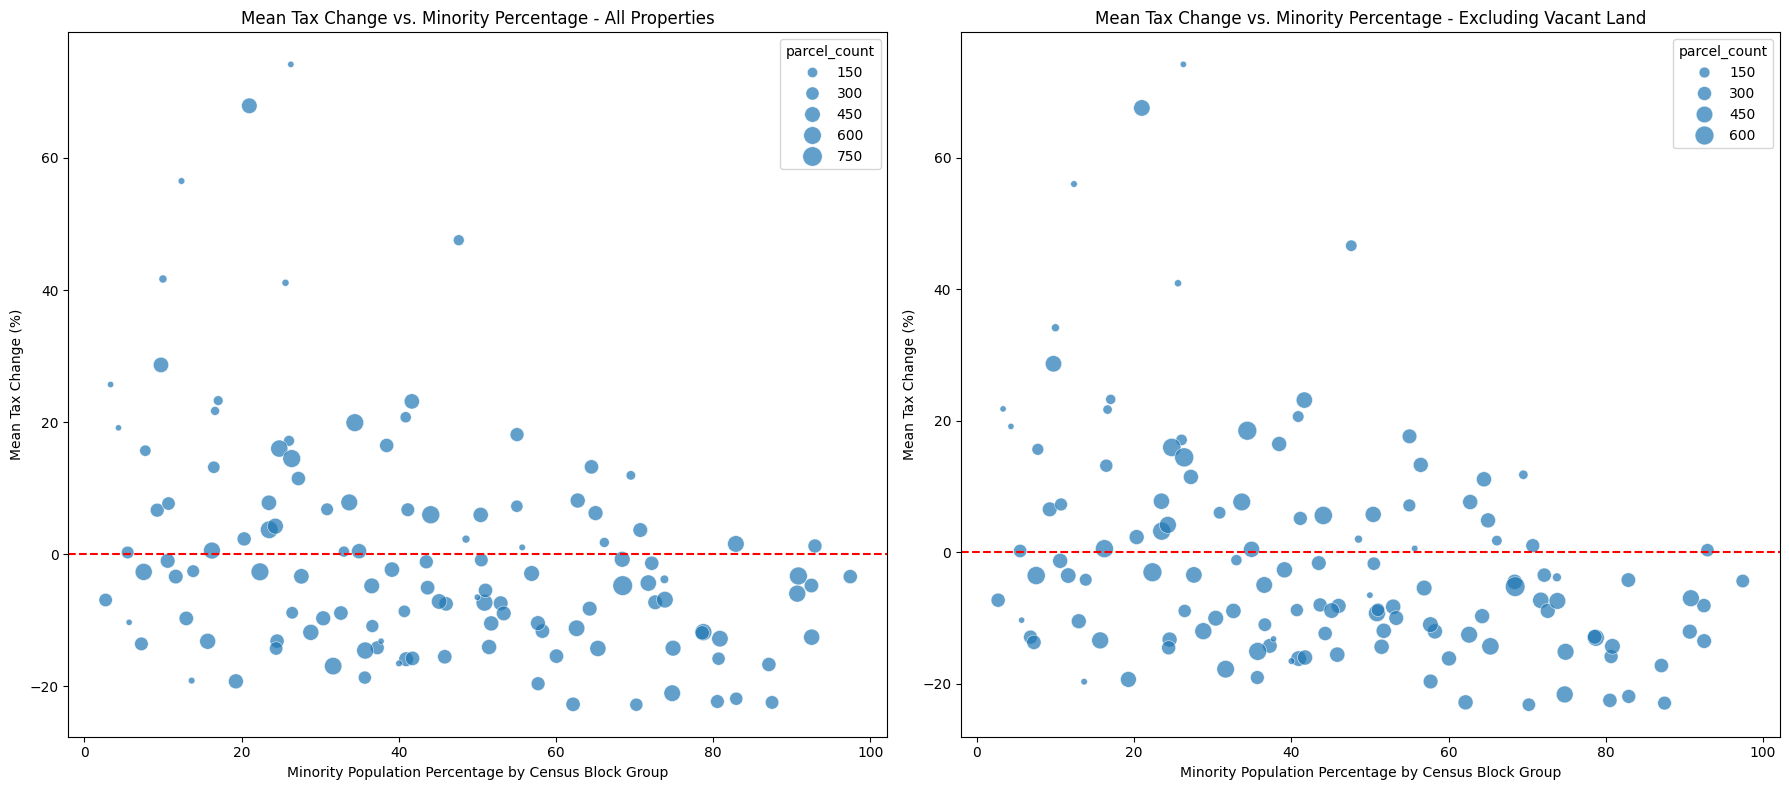

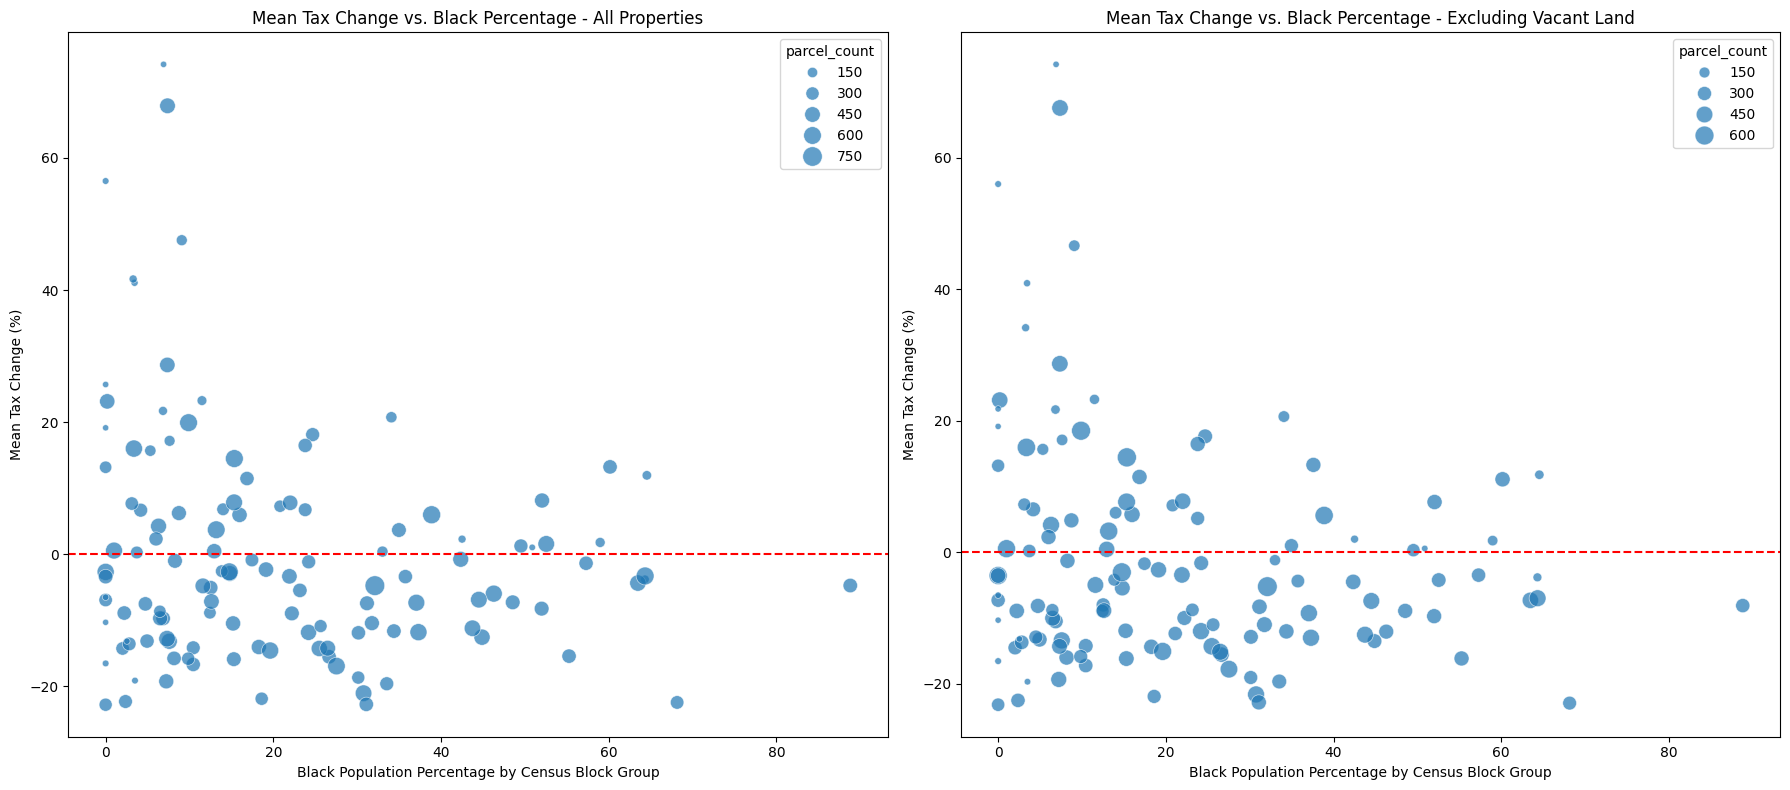

Correlation income_mean_all: 0.1337
Correlation income_median_all: 0.2197
Correlation minority_mean_all: -0.3548
Correlation black_mean_all: -0.1840
Correlation income_mean_non_vacant: 0.0256
Correlation income_median_non_vacant: 0.0653
Correlation minority_mean_non_vacant: -0.3598
Correlation black_mean_non_vacant: -0.1958

Tax impact by income quintile (all properties):


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_12783/3719146301.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').agg(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_12783/3719146301.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').agg(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_12783/3719146301.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

,median_income_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),9167,-8.714903,-25.786917,27915.720737
1,Q2,8672,-21.050373,-44.624103,41423.774216
2,Q3,8488,37.101921,-31.563439,51778.791470
3,Q4,8567,23.515415,-16.984164,63312.479514
4,Q5 (Highest),8708,1.285408,-4.051136,91046.087276



Tax impact by income quintile (excluding vacant land):


,median_income_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),8801,-14.348459,-38.938070,-7.246672e+07
1,Q2,7820,-27.057753,-52.755804,4.152017e+04
2,Q3,8249,33.555921,-36.019650,5.198153e+04
3,Q4,7916,24.474071,-25.150219,6.393839e+04
4,Q5 (Highest),8189,-3.048264,-8.097622,9.168216e+04



Tax impact by minority percentage quintile (all properties):


,minority_pct_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),9096,46.741162,-8.772780,15.140165
1,Q2,8570,27.641661,-23.031321,30.718051
2,Q3,8739,-1.440985,-18.981101,45.355996
3,Q4,8550,-10.410587,-34.420978,63.196387
4,Q5 (Highest),8647,-34.151811,-40.557228,83.080996



Tax impact by minority percentage quintile (excluding vacant land):


,minority_pct_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),8596,41.411185,-17.216536,14.371520
1,Q2,8068,39.349705,-24.478520,29.784969
2,Q3,7998,2.012534,-24.009220,43.415175
3,Q4,8193,-28.296184,-46.376388,60.290447
4,Q5 (Highest),8120,-43.104026,-50.043595,81.066425


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def filter_data(df):
    """Filter data to remove negative median incomes and create non-vacant subset"""
    df_filtered = df[df['median_income'] > 0].copy()
    non_vacant_df = df[df['PROPERTY_CATEGORY'] != 'Vacant Land'].copy()
    return df_filtered, non_vacant_df

def calculate_block_group_summary(df):
    """Calculate summary statistics for census block groups"""
    summary = df.groupby('std_geoid').agg(
        median_income=('median_income', 'first'),
        minority_pct=('minority_pct', 'first'),
        black_pct=('black_pct', 'first'),
        total_current_tax=('current_tax', 'sum'),
        total_new_tax=('new_tax', 'sum'),
        mean_tax_change=('TAX_CHANGE', 'mean'),
        median_tax_change=('TAX_CHANGE', 'median'),
        median_tax_change_pct=('TAX_CHANGE_PCT', 'median'),
        parcel_count=('TAX_CHANGE', 'count'),
        has_vacant_land=('PROPERTY_CATEGORY', lambda x: 'Vacant Land' in x.values)
    ).reset_index()
    
    summary['mean_tax_change_pct'] = ((summary['total_new_tax'] - summary['total_current_tax']) / 
                                    summary['total_current_tax']) * 100
    return summary

def create_scatter_plot(data, x_col, y_col, ax, title, xlabel, ylabel):
    """Create a scatter plot with trend line"""
    sns.scatterplot(
        data=data,
        x=x_col,
        y=y_col,
        size='parcel_count',
        sizes=(20, 200),
        alpha=0.7,
        ax=ax
    )
    
    ax.axhline(y=0, color='r', linestyle='--')
    
    x = data[x_col].dropna()
    y = data[y_col].dropna()
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    if len(x[mask]) > 1:
        z = np.polyfit(x[mask], y[mask], 1)
        p = np.poly1d(z)
        ax.plot(x[mask], p(x[mask]), "r--")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def plot_comparison(data1, data2, x_col, y_col, title_prefix, xlabel):
    """Create side-by-side comparison plots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    create_scatter_plot(data1, x_col, y_col, ax1, 
                       f'{title_prefix} - All Properties', xlabel, 'Mean Tax Change (%)')
    create_scatter_plot(data2, x_col, y_col, ax2,
                       f'{title_prefix} - Excluding Vacant Land', xlabel, 'Mean Tax Change (%)')
    
    plt.tight_layout()
    plt.show()

def calculate_correlations(data1, data2):
    """Calculate correlations between variables"""
    correlations = {}
    for df, suffix in [(data1, 'all'), (data2, 'non_vacant')]:
        correlations[f'income_mean_{suffix}'] = df[['median_income', 'mean_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'income_median_{suffix}'] = df[['median_income', 'median_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'minority_mean_{suffix}'] = df[['minority_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'black_mean_{suffix}'] = df[['black_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
    return correlations

def create_quintile_summary(df, group_col, value_col):
    """Create summary statistics by quintiles"""
    df[f'{group_col}_quintile'] = pd.qcut(df[group_col], 5, 
                                         labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])
    
    summary = df.groupby(f'{group_col}_quintile').agg(
        count=('TAX_CHANGE', 'count'),
        mean_tax_change=('TAX_CHANGE', 'mean'),
        median_tax_change=('TAX_CHANGE', 'median'),
        mean_value=(value_col, 'mean')
    ).reset_index()
    
    return summary

# Main execution
gdf_filtered, non_vacant_gdf = filter_data(df)
print(f"Number of rows in gdf_filtered: {len(gdf_filtered)}")
print(f"Number of rows in non_vacant_gdf: {len(non_vacant_gdf)}")

# Calculate block group summaries
census_block_groups = calculate_block_group_summary(gdf_filtered)
non_vacant_block_summary = calculate_block_group_summary(non_vacant_gdf)

# Create comparison plots
plot_comparison(census_block_groups, non_vacant_block_summary, 
               'median_income', 'mean_tax_change_pct', 
               'Mean Tax Change vs. Median Income', 
               'Median Income by Census Block Group ($)')

plot_comparison(census_block_groups, non_vacant_block_summary,
               'minority_pct', 'mean_tax_change_pct',
               'Mean Tax Change vs. Minority Percentage',
               'Minority Population Percentage by Census Block Group')

plot_comparison(census_block_groups, non_vacant_block_summary,
               'black_pct', 'mean_tax_change_pct',
               'Mean Tax Change vs. Black Percentage',
               'Black Population Percentage by Census Block Group')

# Calculate and print correlations
correlations = calculate_correlations(census_block_groups, non_vacant_block_summary)
for key, value in correlations.items():
    print(f"Correlation {key}: {value:.4f}")

# Create and display quintile summaries
income_quintile_summary = create_quintile_summary(gdf_filtered, 'median_income', 'median_income')
non_vacant_income_quintile_summary = create_quintile_summary(non_vacant_gdf, 'median_income', 'median_income')
minority_quintile_summary = create_quintile_summary(gdf_filtered, 'minority_pct', 'minority_pct')
non_vacant_minority_quintile_summary = create_quintile_summary(non_vacant_gdf, 'minority_pct', 'minority_pct')

print("\nTax impact by income quintile (all properties):")
display(income_quintile_summary)
print("\nTax impact by income quintile (excluding vacant land):")
display(non_vacant_income_quintile_summary)
print("\nTax impact by minority percentage quintile (all properties):")
display(minority_quintile_summary)
print("\nTax impact by minority percentage quintile (excluding vacant land):")
display(non_vacant_minority_quintile_summary)


In [69]:
print("Columns in df:", df.columns.tolist())


Columns in df: ['FID_x', 'PARCELID', 'TAXTYPE', 'TAXUNITUID', 'PARCELSTAT_x', 'LEGALDESCR', 'PAYYEAR', 'NAME_1', 'MAILINGADD', 'MAILINGA_1', 'MAILINGCIT', 'MAILINGSTA', 'MAILINGZIP', 'TIFAREAUID', 'TIFAREASSE', 'REALLANDVA', 'REALIMPROV', 'TLLDIMPROV', 'MAPREFEREN', 'TOWNSHIP', 'TAXDIST', 'TAXUNIT', 'Neighborho', 'CLASSCODE', 'SALESDATE', 'SALESPRICE', 'TRANSFERDA', 'TRANSFERRE', 'PROP_ADDR', 'PROP_CITY', 'PROP_STATE', 'PROP_ZIP', 'Total_Fini', 'PTaxPayYr', 'PastTNetTa', 'ID', 'TaxPayYr', 'TnetTax', 'Exempt1', 'ExemptAmt1', 'Exempt2', 'ExemptAmt2', 'Exempt3', 'ExemptAmt3', 'Exempt4', 'ExemptAmt4', 'Exempt5', 'ExemptAmt5', 'Exempt6', 'ExemptAmt6', 'F_AREA', 'ACREAGE', 'PARCPRC', 'PROVALWBLK', 'PAYTAXURL', 'PROPTYPE', 'TAXINFOURL', 'DATEUPDATE', 'YEAR_BUILT', 'POINT_X', 'POINT_Y', 'Shape__Area_x', 'Shape__Length_x', 'millage_rate', 'exemption_flag', 'total_exemptions', 'taxable_value', 'current_tax', 'land_tax', 'improvement_tax', 'new_tax', 'tax_change', 'tax_change_pct', 'NEW_TAX', 'TA

In [70]:
# Print unique property categories (try common column names)
category_cols = ['property_category', 'PROPERTY_CATEGORY', 'category', 'CATEGORY', 'land_use', 'LAND_USE', 'class', 'CLASS', 'propclass', 'PROPCLASS', 'PARCELSTAT', 'PARCELSTAT_x', 'PARCELSTAT_y']
cat_col = None
for col in category_cols:
    if col in df.columns:
        cat_col = col
        break
if cat_col is not None:
    unique_categories = df[cat_col].dropna().unique()
    print(f"Unique property categories in '{cat_col}':")
    for cat in unique_categories:
        print(f"  {cat}")
else:
    print("No property category column found in DataFrame columns:", df.columns.tolist())


Unique property categories in 'PROPERTY_CATEGORY':
  Vacant Land
  Single Family
  Industrial
  Small Multi-Family (2-19 units)
  Office Commercial
  Food/Hospitality
  Retail Commercial
  Large Multi-Family (20+ units)
  Religious
  Government
  Other Residential
  Parking
  Condominiums
  Charitable
  Other Commercial
  Utility/Infrastructure
  Other Exempt
  Other
  Mobile/Manufactured Homes
  Single Family - Unplatted Small Acreage
  Health/Institutional
  Agricultural
  Single Family - Unplatted Medium Acreage


In [71]:
import numpy as np
import geopandas as gpd
import pandas as pd

# --- Inspect columns for debugging ---
print("Columns in df:", df.columns.tolist())

# Helper to find column with fallback to _x, _y, or other variants
def get_colname(df, base):
    # Try base, then _x, then _y, then case-insensitive match, then substring match
    if base in df.columns:
        return base
    for suffix in ["_x", "_y"]:
        if f"{base}{suffix}" in df.columns:
            return f"{base}{suffix}"
    # Try case-insensitive match
    for col in df.columns:
        if col.lower() == base.lower():
            return col
    # Try substring match (e.g. "land_value" in "LAND_VALUE")
    for col in df.columns:
        if base.lower() in col.lower():
            return col
    return None

# Defensive: check for 'exemption_flag' or variant
exemption_col = get_colname(df, 'exemption_flag')
if exemption_col is None:
    raise KeyError("No 'exemption_flag' column found in DataFrame columns: " + str(df.columns.tolist()))

# Exclude exempt properties (handle missing or all-NA values gracefully)
exemption_mask = df[exemption_col].fillna(False)
if exemption_mask.dtype != bool:
    exemption_mask = exemption_mask.astype(bool)
df_non_exempt = df[~exemption_mask].copy()

# Calculate area in square feet (geometry assumed in meters)
if "geometry" not in df_non_exempt.columns:
    raise AttributeError("GeoDataFrame is missing a 'geometry' column.")
if not isinstance(df_non_exempt, gpd.GeoDataFrame):
    # Try to convert to GeoDataFrame if possible
    try:
        df_non_exempt = gpd.GeoDataFrame(df_non_exempt, geometry="geometry", crs=getattr(df, "crs", None))
    except Exception as e:
        raise TypeError("df_non_exempt is not a GeoDataFrame and could not be converted: " + str(e))

# Ensure geometry is in a projected CRS (meters) for area calculation
if df_non_exempt.crs is None or not df_non_exempt.crs.is_projected:
    # Use Indiana West (EPSG:6493) if available, else fallback to UTM zone 16N (EPSG:26916)
    projected_crs = "EPSG:26916"
    df_non_exempt = df_non_exempt.to_crs(projected_crs)

df_non_exempt['area_sqft'] = df_non_exempt.geometry.area * 10.7639
df_non_exempt['area_sqft'] = df_non_exempt['area_sqft'].replace(0, np.nan)

# --- DEBUG: Print which columns are found for value fields ---
for base in ['REALIMPROV', 'REALLANDVA', 'TLLDIMPROV']:
    col = get_colname(df_non_exempt, base)
    print(f"Column for {base}: {col}")

# Compute per square foot values, only for columns that exist (try _x/_y/other fallback)
# Use 'REALIMPROV' instead of 'improvement_value', 'REALLANDVA' instead of 'land_value', and 'TLLDIMPROV' as full market value
per_sqft_bases = ['new_tax', 'tax_change', 'current_tax', 'REALIMPROV', 'REALLANDVA', 'TLLDIMPROV']
for base in per_sqft_bases:
    col = get_colname(df_non_exempt, base)
    if col is not None:
        per_sqft_col = f"{base}_per_sqft"
        df_non_exempt[per_sqft_col] = df_non_exempt[col] / df_non_exempt['area_sqft']
    else:
        print(f"WARNING: No column found for {base} (tried base/_x/_y/substring)")

# Refined property category assignment
def property_category_refined(row):
    # Helper to get value with _x/_y/substring/case-insensitive fallback
    def get_val(row, base, default=None):
        if base in row:
            return row[base]
        for suffix in ["_x", "_y"]:
            if f"{base}{suffix}" in row:
                return row[f"{base}{suffix}"]
        # Try case-insensitive match
        for col in row.index:
            if col.lower() == base.lower():
                return row[col]
        # Try substring match
        for col in row.index:
            if base.lower() in col.lower():
                return row[col]
        return default

    # Check for PROPERTY_CATEGORY field (with fallback)
    prop_cat = get_val(row, 'PROPERTY_CATEGORY', None)
    if isinstance(prop_cat, str):
        prop_cat_lower = prop_cat.strip().lower()
        if prop_cat_lower == 'vacant land':
            return 'Vacant'
        elif prop_cat_lower == 'parking':
            return 'Parking Lot'

    # Otherwise, use logic as before
    if get_val(row, 'vacant', False):
        return 'Vacant'
    elif get_val(row, 'parking_lot', False):
        return 'Parking Lot'
    else:
        improvement_value = get_val(row, 'REALIMPROV', np.nan)
        land_value = get_val(row, 'REALLANDVA', np.nan)
        if (
            pd.notnull(improvement_value) and 
            pd.notnull(land_value) and 
            land_value > 0 and 
            improvement_value < 0.25 * land_value
        ):
            return 'Underdeveloped'
        else:
            return ''

df_non_exempt['property_category_refined'] = df_non_exempt.apply(property_category_refined, axis=1)

# Exclude condos based on PROPTYPE containing 'condo' (case-insensitive, with fallback)
proptype_col = get_colname(df_non_exempt, 'PROPTYPE')
num_condos = 0
if proptype_col is not None:
    condo_mask = df_non_exempt[proptype_col].astype(str).str.lower().str.contains('condo', na=False)
    num_condos = condo_mask.sum()
    if num_condos > 0:
        print(f"Excluding {num_condos} entries where PROPTYPE includes 'condo'")
    df_non_exempt = df_non_exempt[~condo_mask].copy()
else:
    print("WARNING: No PROPTYPE column found for condo exclusion.")

# Select columns to save, using _x/_y/substring fallback if needed
# Use 'REALIMPROV', 'REALLANDVA', and 'TLLDIMPROV' (as full market value) and their per_sqft columns
# Also save PROPTYPE if available
cols_to_save_bases = [
    'geometry', 'exemption_flag', 'property_category_refined',
    'current_tax', 'current_tax_per_sqft',
    'REALIMPROV', 'REALIMPROV_per_sqft',
    'REALLANDVA', 'REALLANDVA_per_sqft',
    'TLLDIMPROV', 'TLLDIMPROV_per_sqft',
    'PROPERTY_CATEGORY'
]
cols_to_save = []
for base in cols_to_save_bases:
    col = get_colname(df_non_exempt, base)
    if col is not None:
        cols_to_save.append(col)
    else:
        # Only warn for value fields, not geometry/category
        if base not in ['geometry', 'property_category_refined']:
            print(f"WARNING: Output column {base} not found in DataFrame.")

# Ensure output is in WGS84 (EPSG:4326) before saving
if df_non_exempt.crs is None or df_non_exempt.crs.to_epsg() != 4326:
    df_non_exempt = df_non_exempt.to_crs("EPSG:4326")
    print("Converted to EPSG:4326")

# Save as GeoParquet
import os
downloads_path = os.path.expanduser("~/Downloads/southbend_tax_per_sqft.parquet")
output_gdf = df_non_exempt[cols_to_save]
output_gdf.to_parquet(downloads_path, index=False)
print("Saved columns:", output_gdf.columns.tolist())
print("Property category counts:")
print(output_gdf['property_category_refined'].value_counts(dropna=False))
# Print PROPTYPE counts if present
proptype_col_out = get_colname(output_gdf, 'PROPTYPE')
if proptype_col_out is not None:
    print("PROPTYPE counts:")
    print(output_gdf[proptype_col_out].value_counts(dropna=False))
else:
    print("No PROPTYPE column found in output for value counts.")
# Print unique property categories
print("Unique property categories in output:", output_gdf['PROPERTY_CATEGORY'].unique())


Columns in df: ['FID_x', 'PARCELID', 'TAXTYPE', 'TAXUNITUID', 'PARCELSTAT_x', 'LEGALDESCR', 'PAYYEAR', 'NAME_1', 'MAILINGADD', 'MAILINGA_1', 'MAILINGCIT', 'MAILINGSTA', 'MAILINGZIP', 'TIFAREAUID', 'TIFAREASSE', 'REALLANDVA', 'REALIMPROV', 'TLLDIMPROV', 'MAPREFEREN', 'TOWNSHIP', 'TAXDIST', 'TAXUNIT', 'Neighborho', 'CLASSCODE', 'SALESDATE', 'SALESPRICE', 'TRANSFERDA', 'TRANSFERRE', 'PROP_ADDR', 'PROP_CITY', 'PROP_STATE', 'PROP_ZIP', 'Total_Fini', 'PTaxPayYr', 'PastTNetTa', 'ID', 'TaxPayYr', 'TnetTax', 'Exempt1', 'ExemptAmt1', 'Exempt2', 'ExemptAmt2', 'Exempt3', 'ExemptAmt3', 'Exempt4', 'ExemptAmt4', 'Exempt5', 'ExemptAmt5', 'Exempt6', 'ExemptAmt6', 'F_AREA', 'ACREAGE', 'PARCPRC', 'PROVALWBLK', 'PAYTAXURL', 'PROPTYPE', 'TAXINFOURL', 'DATEUPDATE', 'YEAR_BUILT', 'POINT_X', 'POINT_Y', 'Shape__Area_x', 'Shape__Length_x', 'millage_rate', 'exemption_flag', 'total_exemptions', 'taxable_value', 'current_tax', 'land_tax', 'improvement_tax', 'new_tax', 'tax_change', 'tax_change_pct', 'NEW_TAX', 'TA